# A Hands-on Tutorial for Bayesian Neural Networks

(Part 2: classification)

[Yingzhen Li](http://yingzhenli.net/home/en/)

(As part of the BNN lecture at [ProbAI 2022](https://probabilistic.ai/))

In this tutorial, you will implement various Bayesian neural network methods based on variational inference.

We will go through classification tasks to see the applications of uncertainty estimation in practice, including a case study on detecting OOD examples.

**How to use this tutorial notebook?**

*   Read the descriptions in the text;
*   Fill in the missing code whenever you see a block that looks like below:

```
### beginning of your code ###
[insert your own code here]
### end of your code ###
```
There will be hints provided in the code blocks as well to guide you through.

**GPU usage**: For this demo, it is recommended to use GPU to accelate training. To do so, click on "Runtime > Change runtime type", and select "GPU" for the "Hardware accelerator" option.

Let us set up the required packages, and then, enjoy 😊

In [ ]:
%matplotlib inline

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

EPS = 1e-5  # define a small constant for numerical stability control

# Training BNNs on image classfication tasks

In this part you will train a BNN on an image classfication task. More specifically, we will build a Bayesian convolutional neural network (Bayesian CNN) and test a number of approximate posterior inference methods. The dataset in use is MNIST (hand-written digit classification).

Let's set up the MNIST dataset first.

In [ ]:
# setting up the MNIST dataset
transform=transforms.Compose([
        transforms.ToTensor(),])
train_data = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
test_data = datasets.MNIST('../data', train=False,
                       transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



## Implementing a Bayesian CNN with MC dropout

In below we construct a Bayesian CNN with MC dropout and set-up the prediction function with dropout activated.

In [ ]:
# construct a Bayesian CNN for MNIST data
def make_bayesian_cnn(in_channel, n_class, dropout_prob=0.1, activation='LeakyReLU'):
    nonlinearity = getattr(nn, activation)() if isinstance(activation, str) else activation
    net = nn.Sequential()
    # add in conv layers
    channel_sizes = [in_channel, 32, 64, 128]
    for i, (c_in, c_out) in enumerate(zip(channel_sizes[:-1], channel_sizes[1:])):
        net.add_module(f'Conv{i}', nn.Conv2d(c_in, c_out, kernel_size=3, padding='same'))
        if dropout_prob > EPS:  # if setting dropout_prob=0.0 then constructing a deterministic CNN
            net.add_module(f'Dropout{i}', nn.Dropout(dropout_prob))
        net.add_module(f'Nonlinarity{i}', nonlinearity)
        net.add_module(f'Pooling{i}', nn.MaxPool2d(kernel_size=2, ceil_mode=True))
    # add in the last fully connected layer
    # the image sizes goes from 28*28 -> 14*14 -> 7*7 -> 4*4
    net.add_module(f'Flatten', nn.Flatten(start_dim=1, end_dim=-1))
    net.add_module(f'Linear', nn.Linear(128*4*4, n_class))
    return net

# define the prediction function with Monte Carlo sampling using K samples
def predict(bnn, x_test, K=1, use_dropout=True, reduce_mean=True):
    y_pred = []
    if use_dropout:
        bnn.train() # this will turn on dropout in prediction time, if applicable
    else:
        bnn.eval()  # turn off dropout, if applicable
    for _ in range(K):
        y_pred.append(F.softmax(bnn(x_test), dim=-1))
    # shape (K, batch_size, y_dim) or (batch_size, y_dim) if K = 1
    y_pred = torch.stack(y_pred, dim=0).squeeze(0)
    if reduce_mean and K > 1: # "ensemble"
        y_pred = y_pred.mean(0)
    return y_pred

Adding some helper functions...

In [ ]:
def to_numpy(x):
    return x.detach().cpu().numpy() # convert a torch tensor to a numpy array

# helper functions for training
def train_step(net, opt, dataloader, device):
    logs = []
    for _, (x, y) in enumerate(dataloader):
        x = x.to(device); y = y.to(device)
        opt.zero_grad() # opt is the optimiser
        y_logit = net(x)
        # training accruacy (on a mini-batch)
        pred = y_logit.data.max(1, keepdim=True)[1] # get the index of the max logit
        acc = pred.eq(y.data.view_as(pred)).float().cpu().mean()
        # training loss
        nll = F.nll_loss(F.log_softmax(y_logit, dim=-1), y)
        loss = nll  # note that by using AdamW optimizer, weight-decay is implicitly handled there
        loss.backward()
        opt.step()
        logs.append([to_numpy(nll), to_numpy(acc)])
    return np.array(logs)

# define the training function
def train_network(net, opt, dataloader, device, N_epochs=2000, verbose=True):
    net.train()
    logs = []
    for i in range(N_epochs):
        logs_epoch = train_step(net, opt, dataloader, device)
        if verbose:
            print("Epoch {}, last mini-batch nll={}, acc={}".format(i+1, logs_epoch[-1][0], logs_epoch[-1][1]))
        logs.append(logs_epoch)
    return np.concatenate(logs, axis=0)

Now we train a Bayesian CNN using MC-dropout

using cuda:0
Sequential(
  (Conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (Dropout0): Dropout(p=0.1, inplace=False)
  (Nonlinarity0): ReLU()
  (Pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (Conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (Dropout1): Dropout(p=0.1, inplace=False)
  (Nonlinarity1): ReLU()
  (Pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (Conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (Dropout2): Dropout(p=0.1, inplace=False)
  (Nonlinarity2): ReLU()
  (Pooling2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (Linear): Linear(in_features=2048, out_features=10, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 1, last mini-batch nll=0.09077185392379761, acc=0.9599999785423279
Epoch 2, last mini-batch nll=0.04196837544441223, acc=0.9900000095367432
Epoch 3, last mini-batch nll=0.024989120662212372, acc=0.9900000095367432
Epoch 4, last mini-batch nll=0.024478323757648468, acc=0.9900000095367432
Epoch 5, last mini-batch nll=0.019361017271876335, acc=0.9900000095367432


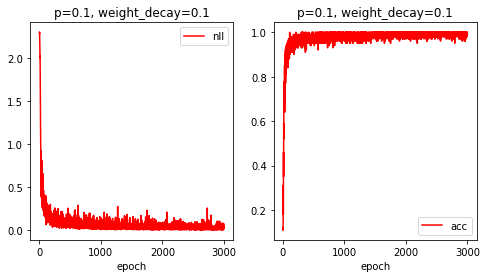

In [ ]:
# constructing and training a Bayesian CNN
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("using {}".format(device))
dropout_prob = 0.1
activation = 'ReLU'
dropout_bnn = make_bayesian_cnn(in_channel=1, n_class=10, dropout_prob=dropout_prob, 
                          activation=activation)
dropout_bnn.to(device)
print(dropout_bnn)

# start training
learning_rate = 1e-3
weight_decay=0.1
N_epochs = 5
# note that weight decay (i.e., prior loss) is implicitly handled by AdamW optimizer
opt = torch.optim.AdamW(dropout_bnn.parameters(), lr=learning_rate, 
                        weight_decay=weight_decay)
# the training loop starts
logs = train_network(dropout_bnn, opt, train_loader, device, N_epochs)

# plot the training curve
def plot_training_loss(logs, dropout_prob, weight_decay):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.plot(np.arange(logs.shape[0]), logs[:, 0], 'r-', label='nll')
    ax2.plot(np.arange(logs.shape[0]), logs[:, 1], 'r-', label='acc')
    ax1.legend()
    ax2.legend()
    ax1.set_xlabel('epoch')
    ax2.set_xlabel('epoch')
    ax1.set_title('p={}, weight_decay={}'.format(dropout_prob, weight_decay))
    ax2.set_title('p={}, weight_decay={}'.format(dropout_prob, weight_decay))
    plt.show()

plot_training_loss(logs, dropout_prob, weight_decay)

Training is finished, we now evaluate its test accuracy. Remember to turn on dropout in test time and do multiple forward passes.

In [ ]:
# test the BNN
def evaluate(model, dataloader, device, K=50):
    accuracy = 0
    for x, y in test_loader:
        x = x.to(device); y = y.to(device)
        # the "predict" function: by default dropout is on and we use K > 1 MC samples
        y_pred = predict(model, x, K, reduce_mean=True)
        pred = y_pred.data.max(1, keepdim=True)[1] # get the index of the max probability
        accuracy += pred.eq(y.data.view_as(pred)).float().cpu().sum()
    accuracy = accuracy / len(dataloader.dataset) * 100 # accuracy in percentage
    return to_numpy(accuracy)

accuracy = evaluate(dropout_bnn, test_loader, device, K=5)
print('Test Accuracy: {}%'.format(accuracy))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Test Accuracy: 99.19999694824219%


## MFVI for Bayesian CNN

We will also train a Bayesian CNN with MFVI approximations. For this we will use the ```Bayesianize``` package. ```Bayesianize``` is a lightweight pytorch package which can convert any MLPs or CNNs to their "Bayesian" version using variational inference.

First we clone and import the package.

In [ ]:
!git clone https://github.com/microsoft/bayesianize.git

Cloning into 'bayesianize'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 74 (delta 14), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (74/74), done.


In [ ]:
import sys
sys.path.append('bayesianize/')
import bnn

We prepare some helper training functions in accordance to the usage of the ```Bayesianize``` package. The idea is similar to the ones in the regression tutorial: we need to compute both the "data losses" (i.e., the negative log-likelihood terms) as well as the KL terms.

In [ ]:
# helper functions for training
def train_bnn_step(net, opt, dataloader, device, beta):
    logs = []
    N_data = len(dataloader.dataset)
    for _, (x, y) in enumerate(dataloader):
        x = x.to(device); y = y.to(device)
        opt.zero_grad() # opt is the optimiser
        y_logit = net(x)
        # training accruacy (on a mini-batch)
        pred = y_logit.data.max(1, keepdim=True)[1] # get the index of the max logit
        acc = pred.eq(y.data.view_as(pred)).float().cpu().mean()
        # training loss
        nll = F.nll_loss(F.log_softmax(y_logit, dim=-1), y)
        kl = sum(m.kl_divergence() for m in net.modules() if hasattr(m, "kl_divergence"))
        loss = N_data * nll + beta * kl
        loss.backward()
        opt.step()
        logs.append([to_numpy(nll), to_numpy(acc), to_numpy(kl)])
    return np.array(logs)

# define the training function
def train_bnn(net, opt, dataloader, device, N_epochs=2000, beta=1.0, verbose=True):
    net.train()
    logs = []
    for i in range(N_epochs):
        logs_epoch = train_bnn_step(net, opt, dataloader, device, beta)
        if verbose:
            print("Epoch {}, last mini-batch nll={}, acc={}, kl={}".format(
                i+1, logs_epoch[-1][0], logs_epoch[-1][1], logs_epoch[-1][2]))
        logs.append(logs_epoch)
    return np.concatenate(logs, axis=0)

Now we train a Bayesian CNN with MFVI as for approximate posterior inference.

Sequential(
  (Conv0): FFGConv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, prior mean=0.00, prior sd=1.00)
  (Nonlinarity0): ReLU()
  (Pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (Conv1): FFGConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, prior mean=0.00, prior sd=1.00)
  (Nonlinarity1): ReLU()
  (Pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (Conv2): FFGConv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, prior mean=0.00, prior sd=1.00)
  (Nonlinarity2): ReLU()
  (Pooling2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (Linear): FFGLinear(in_features=2048, out_features=10, bias=True, prior mean=0.00, prior sd=1.00)
)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 1, last mini-batch nll=0.08229530602693558, acc=0.9800000190734863, kl=322783.625
Epoch 2, last mini-batch nll=0.03010711260139942, acc=0.9900000095367432, kl=261299.515625
Epoch 3, last mini-batch nll=0.11150902509689331, acc=0.9599999785423279, kl=205361.4375
Epoch 4, last mini-batch nll=0.03091660514473915, acc=0.9800000190734863, kl=158070.546875
Epoch 5, last mini-batch nll=0.1486053615808487, acc=0.949999988079071, kl=120133.6953125


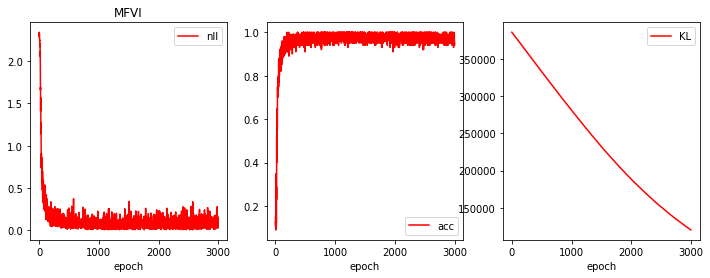

In [ ]:
activation = 'ReLU'
# use dropout_prob = 0.0 effectively constructs a deterministic CNN
mfvi_bnn = make_bayesian_cnn(in_channel=1, n_class=10, dropout_prob=0.0, 
                             activation=activation)
# use the "Bayesianize" package to make a Bayesian CNN with MFVI
# inference='ffg' means using fully-factorised Gaussian for VI, i.e., MFVI
# see https://github.com/microsoft/bayesianize/blob/main/bnn/nn/mixins/variational/ffg.py
bnn.bayesianize_(mfvi_bnn, inference='ffg', init_sd=0.02)
mfvi_bnn.to(device)
print(mfvi_bnn)

# start training
learning_rate = 1e-3
N_epochs = 5
beta = 1.0
opt = torch.optim.Adam(mfvi_bnn.parameters(), lr=learning_rate)
# the training loop starts
logs = train_bnn(mfvi_bnn, opt, train_loader, device, N_epochs, beta)

# plot the training curve
def plot_training_loss(logs, title):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    ax1.plot(np.arange(logs.shape[0]), logs[:, 0], 'r-', label='nll')
    ax2.plot(np.arange(logs.shape[0]), logs[:, 1], 'r-', label='acc')
    ax3.plot(np.arange(logs.shape[0]), logs[:, 2], 'r-', label='KL')
    for ax in [ax1, ax2, ax3]:
        ax.legend()
        ax.set_xlabel('epoch')
        ax1.set_title(title)
    plt.show()

plot_training_loss(logs, title='MFVI')

Training is finished, then we evaluate the accuracy of MFVI Bayesian CNN.

In [ ]:
accuracy = evaluate(mfvi_bnn, test_loader, device, K=5)
print('Test Accuracy: {}%'.format(accuracy))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Test Accuracy: 98.63999938964844%


# Case study 2: Detecting adversarial attacks

Neural networks has been shown to be vulnerable to adversarial attacks. In this case study, we will see whether BNNs can be more robust or not, as well as how to use uncertainty measures from BNNs to detect adversarial examples.


But first let's set-up the helper functions for the adversarial attack. Here we consider the $L_\infty$-norm projected gradient descent (PGD) attack [(Madry et al. ICLR 2018)](https://arxiv.org/abs/1706.06083) which is one of the strongest attack considerred in adversarial robustness literature.

In [ ]:
# PGD attack for one step
def pgd_one_step(x, x_grad, x_clean, epsilon, lr, x_min, x_max):
    # use scaled element-wise sign of the data gradient for attack
    x_adv = x + lr * x_grad.sign()
    x_adv = torch.clamp(x_adv, min=x_min, max=x_max)  # make sure x is valid
    # project the attack back to the epsilon-ball (L-inf norm)
    x_adv = x_clean + torch.clamp(x_adv - x_clean, min=-epsilon, max=epsilon)
    return x_adv

def pgd_attack(x, y, model, predict_func, epsilon, T, lr, x_min, x_max):
    x_adv = x.detach().clone()
    x_adv.requires_grad = True  # we need to compute gradients w.r.t. the input
    # perform PGD attack for T steps
    for t in range(T):
        # Forward pass the data through the model and get loss
        y_pred = predict_func(x_adv, reduce_mean=True) # return prediction probabilities
        loss = F.nll_loss(torch.log(torch.clamp(y_pred, min=EPS)), y)
        # One-step PGD using gradients of loss w.r.t. input in backward pass
        if type(model) is list:
            for net in model:
                net.zero_grad()
        else:
            model.zero_grad()
        loss.backward()
        x_adv.data = pgd_one_step(x_adv.data, x_adv.grad.data, x, epsilon, lr, x_min, x_max)
    return x_adv

We first test the PGD attack on a deterministic network (as to validate the implementation). For this deterministic network, we just need to turn off dropout during test time.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


entropy (clean) 0.048386477
clean accruacy for this batch: 100.0%
adv accruacy for this batch (%): [95. 79. 29.  2.  0.  0.  0.  0.]


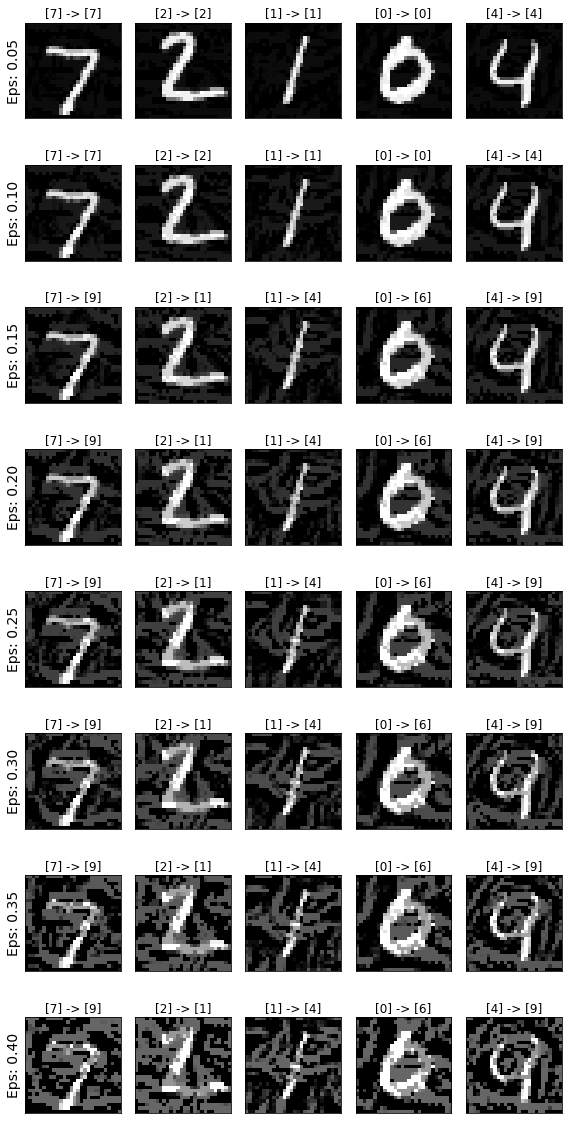

In [ ]:
# testing adversarial attacks
# we will use 100 test samples as examples
x_test, y_test = next(iter(test_loader))
x_test = torch.tensor(x_test, device=device)
y_test = torch.tensor(y_test, device=device)

# define some helper functions for the attack
def run_attack(model, x_test, y_test, predict_func, epsilon_list, T):
    acc_adv = []
    pred_adv = []
    prob_adv = []
    x_adv = []
    for epsilon in epsilon_list:
        lr = epsilon / T * 1.5
        x_adv_ = pgd_attack(x_test, y_test, model, predict_func, 
                           epsilon, T, lr, x_min=0.0, x_max=1.0)
        # get the accuracy on crafted adversarial examples
        y_pred = predict_func(x_adv_, reduce_mean=True)
        pred = y_pred.data.max(1, keepdim=True)[1] # get the index of the max probability
        acc_adv.append(to_numpy(pred.eq(y_test.data.view_as(pred)).float().mean()))
        pred_adv.append(to_numpy(pred))
        prob_adv.append(to_numpy(y_pred))
        x_adv.append(to_numpy(x_adv_))
    return np.array(acc_adv), np.array(pred_adv), np.array(prob_adv), np.array(x_adv)

# helper function for visualization
def visualize(images, epsilons, pred_clean, pred_adv):
    cnt = 0
    plt.figure(figsize=(8, 2 * len(epsilons)))
    for i in range(len(epsilons)):
        for j in range(len(images[i])):
            cnt += 1
            plt.subplot(len(epsilons),len(images[0]),cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            if j == 0:
                plt.ylabel("Eps: {:.2f}".format(epsilons[i]), fontsize=14)
            plt.title("{} -> {}".format(pred_clean[j], pred_adv[i, j]))
            plt.imshow(images[i, j][0], cmap="gray")
    plt.tight_layout()
    plt.show()

# we first test a deterministic NN's robustness, by turning off dropout
predict_deterministic = lambda x, reduce_mean: predict(dropout_bnn, x, K=1, use_dropout=False, 
                                                       reduce_mean=reduce_mean)

def test_robustness(model, predict_func, x_test, y_test):
    # first test clean accuracy
    y_pred = predict_func(x_test, reduce_mean=True)
    entropy = -(y_pred * torch.log(y_pred)).sum(-1).mean()
    print("entropy (clean)", to_numpy(entropy))
    pred_clean = y_pred.data.max(1, keepdim=True)[1] # get the index of the max probability
    acc_clean = to_numpy(pred_clean.eq(y_test.data.view_as(pred_clean)).float().mean())
    pred_clean = to_numpy(pred_clean)
    print("clean accruacy for this batch: {}%".format(acc_clean * 100))
    
    # now run the attack
    T = 10
    epsilon_list = np.arange(0.05, 0.41, 0.05)
    acc_adv, pred_adv, prob_adv, x_adv = run_attack(model, x_test, y_test, predict_func, epsilon_list, T)
    print("adv accruacy for this batch (%): {}".format(acc_adv * 100))
    # visualise the adversarial examples
    visualize(x_adv[:, :5], epsilon_list, pred_clean[:5], pred_adv[:, :5])
    return x_adv

x_adv = test_robustness(dropout_bnn, predict_deterministic, x_test, y_test)

Now testing the MC-dropout Bayesian CNN's robustness. 

In this case we will also look at the uncertainty produced by the BNN on the adversarial examples. Specifically, you will implement:

*   total uncertainty: as the total entropy
*   aleatoric uncertainty: as the conditional entropy

Epistemic uncertainty is the mutual information which is essentially total entropy minus conditional entropy.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


entropy (clean) 0.031681836
clean accruacy for this batch: 100.0%
adv accruacy for this batch (%): [95. 82. 32.  2.  0.  0.  0.  0.]


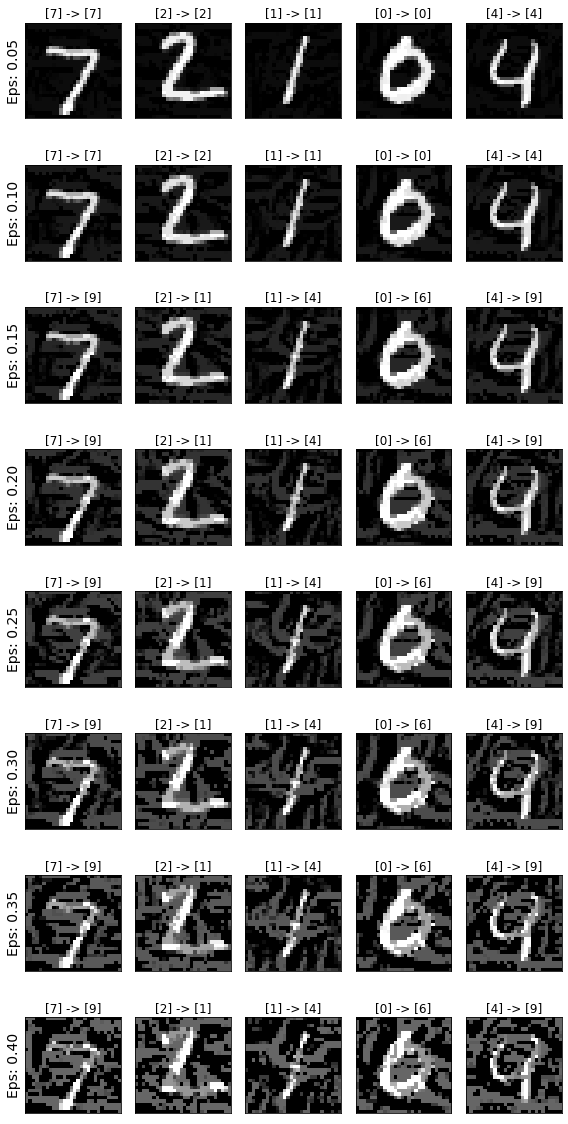

total uncertainty (entropy): [0.11934087 0.3424316  0.52679455 0.25995743 0.0980616  0.0801347
 0.07231481 0.11620294]
aleatoric uncertainty (cond. entropy): [0.11407898 0.3258734  0.50757354 0.25181732 0.09615013 0.078594
 0.07047283 0.11284649]
epistemic uncertainty (mutual info): [0.00526189 0.0165582  0.01922101 0.00814012 0.00191147 0.0015407
 0.00184198 0.00335645]


In [ ]:
# now we test Bayesian CNN's robustness, by using MC-dropout
predict_mcdropout = lambda x, reduce_mean: predict(dropout_bnn, x, K=5, use_dropout=True,
                                                   reduce_mean=reduce_mean)
x_adv = test_robustness(dropout_bnn, predict_mcdropout, x_test, y_test)

# also compute uncertainty measures

def total_entropy(y_prob_samples):
    y_prob = y_prob_samples.mean(0)
    return -(y_prob * torch.log(y_prob)).sum(-1)

def conditional_entropy(y_prob_samples):
    return -(y_prob_samples * torch.log(y_prob_samples)).sum(-1).mean(0)

def compute_uncertainty(predict_func, x_adv, reduce_mean=True):
    logs = []
    for i in range(x_adv.shape[0]):
        x = torch.tensor(x_adv[i], device=device)
        y_prob_samples = predict_func(x, reduce_mean=False)
        entropy = total_entropy(y_prob_samples)
        cond_entropy = conditional_entropy(y_prob_samples)
        if reduce_mean:
            entropy = entropy.mean(); cond_entropy = cond_entropy.mean()
        mutual_info = entropy - cond_entropy
        logs.append([to_numpy(entropy), to_numpy(cond_entropy), to_numpy(mutual_info)])
    return np.array(logs)

logs = compute_uncertainty(predict_mcdropout, x_adv)
print("total uncertainty (entropy):", logs[:, 0])
print("aleatoric uncertainty (cond. entropy):", logs[:, 1])
print("epistemic uncertainty (mutual info):", logs[:, 2])

And similarly for the MFVI Bayesian CNN, test its adversarial robustness.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


entropy (clean) 0.09574664
clean accruacy for this batch: 98.99999499320984%
adv accruacy for this batch (%): [91.99999 76.      44.      14.       1.       0.       0.       0.     ]


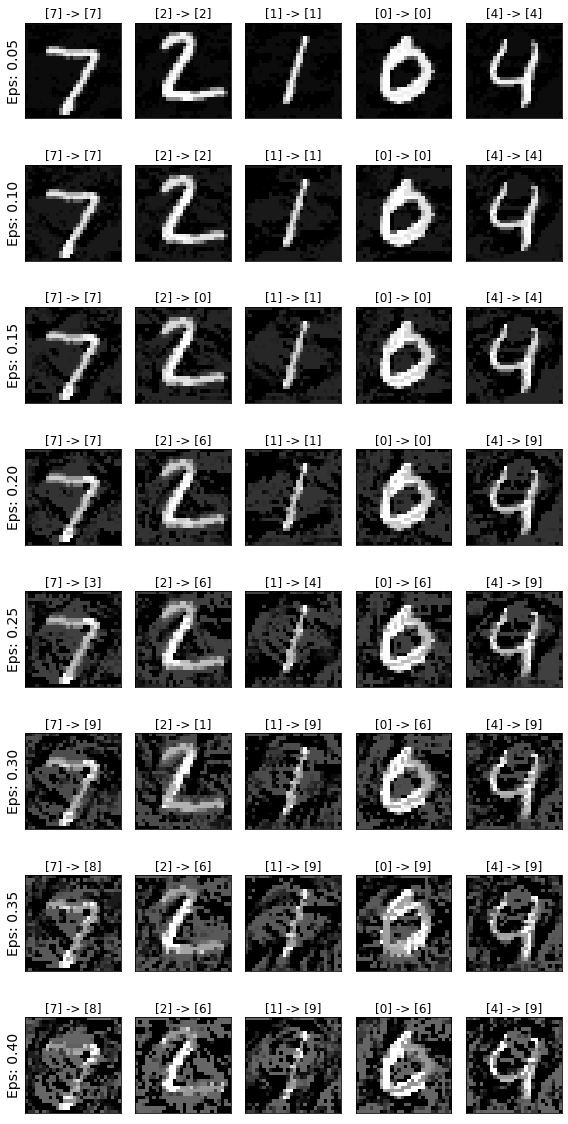

total uncertainty (entropy): [0.26186725 0.53992885 0.7552825  0.7608884  0.67691636 0.5337778
 0.4432854  0.4012931 ]
aleatoric uncertainty (cond. entropy): [0.18721826 0.3845276  0.54575104 0.5465816  0.5060795  0.4052427
 0.32411587 0.28704536]
epistemic uncertainty (mutual info): [0.07464899 0.15540126 0.20953149 0.21430677 0.17083687 0.12853506
 0.11916953 0.11424774]


In [ ]:
# now we test Bayesian CNN's robustness, by using MFVI
predict_mfvi = lambda x, reduce_mean: predict(mfvi_bnn, x, K=5, reduce_mean=reduce_mean)
x_adv = test_robustness(mfvi_bnn, predict_mfvi, x_test, y_test)
# also compute epistemic uncertainty
logs = compute_uncertainty(predict_mfvi, x_adv)
print("total uncertainty (entropy):", logs[:, 0])
print("aleatoric uncertainty (cond. entropy):", logs[:, 1])
print("epistemic uncertainty (mutual info):", logs[:, 2])

## Can ensembles help?

From the above examples we see that the trained BNNs help a bit in adversarial robustness but not too much, especially for the MC-dropout one. From the printed uncertainty measures, we suspect the trained networks may be still not uncertain enough on the adversarial examples.

Next we will train an Ensemble of MFVI-BNNs. This means we will train multiple MFVI-BNNs independently with different random initialisation of the variational parameters, and then ensemble them together to get the final model. Although diversity is not explicitly encouraged, the hope is that the randomness in initialisation and SGD steps would allow different independent runs to result in different local optima, resulting in a more diversed set of neural networks.

Please run the code in below block, it might take a few minutes to train the MFVI-BNNs in the ensemble.

In [ ]:
# train an ensemble of MFVI networks (independently) and see what happens
mfvi_bnn_list = [mfvi_bnn]
N_ensemble = 5
activation = 'ReLU'
learning_rate = 1e-3
N_epochs = 5
beta = 1.0

for i in range(1, N_ensemble):
    print("train a new MFVI CNN (network {})".format(i+1))
    net = make_bayesian_cnn(in_channel=1, n_class=10, dropout_prob=0.0, 
                            activation=activation)
    bnn.bayesianize_(net, inference='ffg', init_sd=0.02)
    net.to(device)
    print(net)
    # start training
    opt = torch.optim.Adam(net.parameters(), lr=learning_rate)
    logs = train_bnn(net, opt, train_loader, device, N_epochs, beta)
    mfvi_bnn_list.append(net)

train a new MFVI CNN (network 2)
Sequential(
  (Conv0): FFGConv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, prior mean=0.00, prior sd=1.00)
  (Nonlinarity0): ReLU()
  (Pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (Conv1): FFGConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, prior mean=0.00, prior sd=1.00)
  (Nonlinarity1): ReLU()
  (Pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (Conv2): FFGConv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, prior mean=0.00, prior sd=1.00)
  (Nonlinarity2): ReLU()
  (Pooling2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (Linear): FFGLinear(in_features=2048, out_features=10, bias=True, prior mean=0.00, prior sd=1.00)
)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch 1, last mini-batch nll=0.10069575905799866, acc=0.9700000286102295, kl=322410.0
Epoch 2, last mini-batch nll=0.029820876196026802, acc=0.9900000095367432, kl=260510.546875
Epoch 3, last mini-batch nll=0.09871918708086014, acc=0.9700000286102295, kl=204004.53125
Epoch 4, last mini-batch nll=0.04804856702685356, acc=0.9800000190734863, kl=156878.75
Epoch 5, last mini-batch nll=0.02621012181043625, acc=0.9900000095367432, kl=119781.921875
train a new MFVI CNN (network 3)
Sequential(
  (Conv0): FFGConv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, prior mean=0.00, prior sd=1.00)
  (Nonlinarity0): ReLU()
  (Pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (Conv1): FFGConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, prior mean=0.00, prior sd=1.00)
  (Nonlinarity1): ReLU()
  (Pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (Conv2): FFGConv2d(64, 128, kernel_size=(3, 3), stride=(1, 1),

Training is now finished, let's see how the ensemble performs on clean data.

In [ ]:
# test the ensemble on clean test data
def predict_ensemble(x_test, K=5, reduce_mean=True):
    y_prob_samples = []
    for net in mfvi_bnn_list:
        y_prob_samples.append(predict(net, x_test, K=K, reduce_mean=False))
    y_prob_samples = torch.concat(y_prob_samples, axis=0)
    if reduce_mean:
        return y_prob_samples.mean(0)
    else:
        return y_prob_samples

accuracy = 0
K = 5
for x, y in test_loader:
    x = x.to(device); y = y.to(device)
    y_pred = predict_ensemble(x, K)
    pred = y_pred.data.max(1, keepdim=True)[1] # get the index of the max probability
    accuracy += pred.eq(y.data.view_as(pred)).float().cpu().sum()
accuracy = to_numpy(accuracy / len(test_loader.dataset) * 100) # accuracy in percentage
print('Test Accuracy: {}%'.format(accuracy))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Test Accuracy: 99.0199966430664%


Then we perform PGD attacks on the ensemble BNN.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


entropy (clean) 0.10990928
clean accruacy for this batch: 100.0%
adv accruacy for this batch (%): [94. 77. 42.  6.  0.  0.  0.  0.]


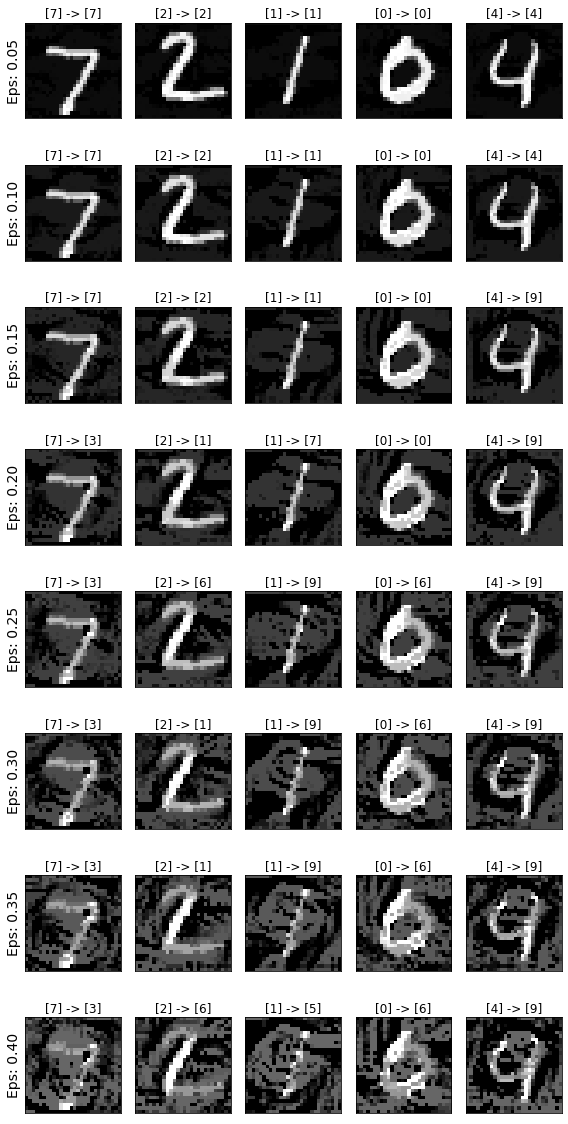

total uncertainty (entropy): [0.34317023 0.70485646 0.9586889  0.98697364 0.86825347 0.80917144
 0.7803755  0.73641235]
aleatoric uncertainty (cond. entropy): [0.20037204 0.44248432 0.62013936 0.69085914 0.63022095 0.58786035
 0.5421429  0.485346  ]
epistemic uncertainty (mutual info): [0.14279819 0.26237214 0.33854955 0.2961145  0.23803252 0.22131109
 0.23823255 0.25106636]


In [ ]:
# test for adversarial attacks
x_adv = test_robustness(mfvi_bnn_list, predict_ensemble, x_test, y_test)
# also compute epistemic uncertainty
logs = compute_uncertainty(predict_ensemble, x_adv)
print("total uncertainty (entropy):", logs[:, 0])
print("aleatoric uncertainty (cond. entropy):", logs[:, 1])
print("epistemic uncertainty (mutual info):", logs[:, 2])

# Quantitative metric for detection results

The ensemble BNN above makes a bit of improvement on robustness but not too much, however, in terms of uncertainty measures, the ensemble becomes more uncertain on the adversarial inputs. But at the same time, the total entropy on clean inputs remains relatively close to the single MFVI-BNN case. This is helpful as it will be easier to separate clean/adversarial examples by looking at the uncertainty measures and picking appropriate thresholds for dectection.

In below blocks, we will quantify the quality of uncertainty by considering its effectiveness as a tool for adversarial example detection. The idea is, for a given uncertainty measure (e.g., total entropy):

*   for a given threshold, predict the input as "adversarial" if uncertainty > threshold;
*   search for the best threshold so that it returns the best true positive rate (TPR) of detecting adversarial example, while maintaining the false positive rate (FPR) to be below 5%.



In [ ]:
# below are helper functions for the adversarial example detection test

def get_uncertainty_adv_examples(model, predict_func, x_test, y_test, epsilon_list, T=10):
    # first get uncertainties on clean examples, return tensor of shape (3, batch_size)
    uncertainty_clean = compute_uncertainty(predict_func, x_test.unsqueeze(0), reduce_mean=False)[0]
    # now run the attack
    acc_adv, pred_adv, prob_adv, x_adv = run_attack(model, x_test, y_test, predict_func, epsilon_list, T)
    print("adv accruacy for this batch (%): {}".format(acc_adv * 100))
    # get uncertainties on adversarial examples, return tensor of shape (len(epsilon_list, 3, batch_size))
    uncertainty_adv = compute_uncertainty(predict_func, x_adv, reduce_mean=False)
    return uncertainty_clean, uncertainty_adv

def compute_detection_error(thresholds, uncertainty, label):
    # compute the detection error
    # here if uncertainty > threshold then we say it is an OOD example
    # where for label, 0 means in-distribution, 1 means OOD
    # we assume the first half of the labels are 0 and the second half of the labels are 1
    tpr = []; fpr = []
    N = int(label.shape[0] / 2)
    for t in thresholds:
        pred = np.maximum(np.sign(uncertainty - t), 0)
        fpr.append(1 - np.mean(np.where(pred[:N] == label[:N], 1, 0)))
        tpr.append(np.mean(np.where(pred[N:] == label[N:], 1, 0)))
    return fpr, tpr

def run_detect(model, x_test, y_test, predict_func, epsilon_list, min_fpr = 0.05):
    thresholds = np.arange(0.0, np.log(10), 0.05)
    fpr_total = 0.0; tpr_total = 0.0
    N_data = x_test.shape[0]; batch_size = 100; N_batches = int(N_data / batch_size)
    for n in range(N_batches):
        x = x_test[n*batch_size:(n+1)*batch_size].to(device)
        y = y_test[n*batch_size:(n+1)*batch_size].to(device)
        uncertainty_clean, uncertainty_adv = get_uncertainty_adv_examples(model, predict_func, x, y, epsilon_list)
        # we assume the first half of the labels are 0 and the second half of the labels are 1
        label = np.concatenate([np.zeros(x.shape[0]), np.ones(x.shape[0])])
        # len(uncertainty_adv) == len(epsilon_list)
        fpr = np.zeros((len(uncertainty_adv), 3, len(thresholds)))
        tpr = np.zeros((len(uncertainty_adv), 3, len(thresholds)))
        for i in range(len(uncertainty_adv)):
            for j in range(3):
                uncertainty = np.concatenate([uncertainty_clean[j], uncertainty_adv[i][j]])
                fpr[i, j], tpr[i, j] = compute_detection_error(thresholds, uncertainty, label)
        fpr_total = fpr_total + fpr * batch_size / N_data
        tpr_total = tpr_total + tpr * batch_size / N_data
    # now we compute the best tpr given that the corresponding fpr <= min_fpr
    mask = np.where(fpr_total <= min_fpr, 1, 0)
    tpr_best = np.max(tpr_total * mask, axis=-1)
    # plot the result
    plt.subplots(1, 1, figsize=(5, 4))
    plt.plot(epsilon_list, tpr_best[:, 0], 'k-', label='total entropy')
    plt.plot(epsilon_list, tpr_best[:, 1], 'b-', label='cond entropy')
    plt.plot(epsilon_list, tpr_best[:, 2], 'r-', label='mutual info')
    plt.legend()
    plt.xlabel('epsilon')
    plt.title('Best TPR (with FPR <= %.2f)' % min_fpr)
    plt.show()
    return tpr_best

Now we can test for adversarial detection. To do so, we randomly sample 1000 (10*100) datapoints from the test data.

In [ ]:
# get N_batch*100 test images to test detection
count_batch = 0
N_batch = 10
x_clean = []; y_clean = []
for x, y in test_loader:
    x_clean.append(x); y_clean.append(y)
    count_batch += 1
    if count_batch >= N_batch:
        break
x_clean = torch.concat(x_clean, dim=0); y_clean = torch.concat(y_clean, dim=0)

First we evaluate the MC-dropout method.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


adv accruacy for this batch (%): [96. 82. 33.  2.  0.  0.  0.  0.]
adv accruacy for this batch (%): [96. 76. 38.  2.  0.  0.  0.  0.]
adv accruacy for this batch (%): [95. 71. 24.  1.  0.  0.  0.  0.]
adv accruacy for this batch (%): [94.       75.       26.999998  1.        0.        0.        0.
  0.      ]
adv accruacy for this batch (%): [90. 62. 18.  3.  0.  0.  0.  0.]
adv accruacy for this batch (%): [95. 72. 22.  1.  0.  0.  0.  0.]
adv accruacy for this batch (%): [91.99999 72.      34.       2.       0.       0.       0.       0.     ]
adv accruacy for this batch (%): [96.      79.99999 26.       2.       0.       0.       0.       0.     ]
adv accruacy for this batch (%): [89. 72. 26.  0.  0.  0.  0.  0.]
adv accruacy for this batch (%): [91.99999  70.       22.999998  1.        0.        0.        0.
  0.      ]


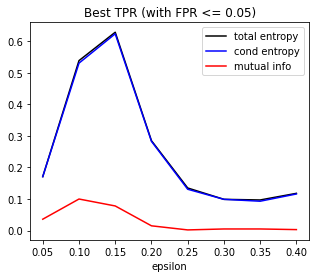

In [ ]:
# test detection for the MC-dropout net
epsilon_list = np.arange(0.05, 0.41, 0.05)
tpr_dropout = run_detect(dropout_bnn, x_clean, y_clean, predict_mcdropout, epsilon_list)

Then we evaluate the MFVI Bayesian CNN.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


adv accruacy for this batch (%): [91. 77. 39. 12.  0.  0.  0.  0.]
adv accruacy for this batch (%): [95. 76. 48. 12.  3.  0.  0.  0.]
adv accruacy for this batch (%): [93. 71. 37. 13.  2.  0.  0.  0.]
adv accruacy for this batch (%): [94.      66.99999 38.      17.       0.       0.       0.       0.     ]
adv accruacy for this batch (%): [87. 66. 31.  4.  2.  0.  0.  0.]
adv accruacy for this batch (%): [91.99999 72.99999 33.       9.       0.       0.       0.       0.     ]
adv accruacy for this batch (%): [93. 66. 37. 13.  1.  0.  0.  0.]
adv accruacy for this batch (%): [95.       74.       42.999996 14.        0.        0.        0.
  0.      ]
adv accruacy for this batch (%): [91.99999 76.      37.      11.       1.       0.       0.       0.     ]
adv accruacy for this batch (%): [91.99999 72.99999 37.      13.       0.       0.       0.       0.     ]


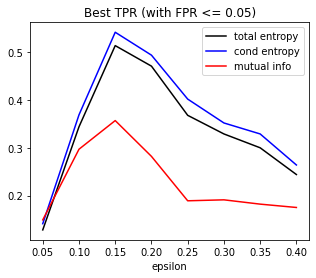

In [ ]:
# test detection for the mfvi net
tpr_mfvi = run_detect(mfvi_bnn, x_clean, y_clean, predict_mfvi, epsilon_list)

Finally we evaluate the ensemble MFVI Bayesian CNN.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


adv accruacy for this batch (%): [91.99999   76.        44.         4.9999995  0.         0.
  0.         0.       ]
adv accruacy for this batch (%): [97.       79.99999  45.999996  7.        0.        0.        0.
  0.      ]
adv accruacy for this batch (%): [96.       78.       39.999996 11.        0.        0.        0.
  0.      ]
adv accruacy for this batch (%): [95. 78. 39.  6.  0.  0.  0.  0.]
adv accruacy for this batch (%): [91. 70. 29.  6.  0.  0.  0.  0.]
adv accruacy for this batch (%): [96. 81. 28.  4.  0.  0.  0.  0.]
adv accruacy for this batch (%): [93. 79. 42.  8.  0.  0.  0.  0.]
adv accruacy for this batch (%): [93.        79.99999   48.999996   4.9999995  1.         0.
  0.         0.       ]
adv accruacy for this batch (%): [94. 76. 38.  8.  0.  0.  0.  0.]
adv accruacy for this batch (%): [95.      72.99999 38.       8.       0.       0.       0.       0.     ]


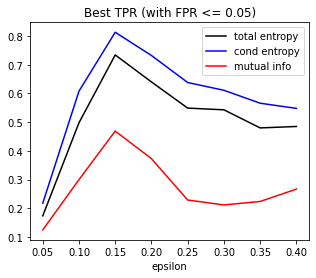

In [ ]:
# test detection for the ensemble method
tpr_ensemble = run_detect(mfvi_bnn_list, x_clean, y_clean, predict_ensemble, epsilon_list)

Hopefully you can see that the ensemble BNN performs significantly better than the other two BNNs (MC-dropout and single MFVI-BNN) in terms of detecting adversarial examples.

There are ways to improve the ensemble BNN further in terms of both robustness and detection to adversarial examples, but they are beyond the scope of this tutorial.